In [1]:
import numpy as np
import pickle
import os, sys
sys.path.append(os.path.dirname(os.getcwd()) + '/source')
import sympy

import matplotlib.pyplot as plt
import matplotlib as mpl

from numba import njit

mpl.rcParams['font.size'] = 20
# mpl.rcParams['figure.figsize'] = (12, 8)
mpl.rcParams['figure.facecolor'] = 'white'
mpl.rcParams['figure.autolayout'] = True
np.random.seed(0)

In [2]:
def get_quantile(simulation, quantileList=[.1, .33, .5, .67, .9]):
    quantileDict = dict()
    for quantile in quantileList:
        quantileDict[quantile] = np.quantile(simulation, quantile, axis=0)
        
    return quantileDict

In [3]:
def plot_quantile(quantDict, quantileList = [.1, .33, .5, .67, .9]):
    for quantile in reversed(quantileList):
        plt.plot(quantDict[quantile], label="{} quantile".format(quantile))
    plt.legend()

In [4]:
@njit
def simulate_ye(Ys, e, z, T=102, dt=1):
    """e, y for each value of z_2"""
    numz, = z.shape
    periods = int(T/dt)
    et = np.zeros((numz, periods))
    yt = np.zeros((numz, periods))
    yt[:, 0]= 870-580
    for i in range(numz):
        y = yt[i,0]
        for t in range(periods):
            loc = (np.abs(Y - y)).argmin()
            et[i, t] =  e[i, loc]
            y = y + et[i, t]*dt
            yt[i, t] = y
    return et, yt

In [5]:
def simulate_z(dW, z0, alpha_z, beta_z, sigma_z, Ht=0, dt=1):
    _, path, time = dW.shape
    zt = np.zeros((path, time))
    zt[:, 0] = z0
    z = z0
    for t in range(time-1):
        dz = (alpha_z - beta_z*z)*dt+ np.dot(sigma_z*np.sqrt(dt), Ht + dW[:, :, t])
        z = dz + z
        zt[:,t+1] = z
    return zt

In [6]:
@njit
def simulate_z2(dW2, z0, rho=.9, mu_2=1.86/1000, sigma_2=np.sqrt((.21/1000)**2*2*.9/(1.86/1000)), T=102, dt=1):
    path, _ = dW2.shape
    periods = int(T/dt)
    zt = np.zeros((path, periods))
    zt[:,0] = z0
    path, time = dW2.shape
    for p in range(path):
        z = zt[p,0]
        for t in range(periods-1):
            dz = -rho*(z-mu_2)*dt + np.sqrt(z)*sigma_2*np.sqrt(dt)*dW2[p,t] 
            z = z + dz
            zt[p, t+1] = z
    return zt

In [7]:
@njit
def simulate_logkapital( invkap, dW2, zt, alpha_k, beta, sigma_k, kappa, k0, Ht=0, T=102,dt=1):
    _, path, time = dW.shape
    periods = int(T/dt)
    Kt = np.zeros((path, periods))
    i = invkap
     # log capital
    Kt[:, 0] = np.log(k0)
    k = np.log(k0)*np.ones(path)
    for t in range(periods-1):
        k +=   (alpha_k + beta*zt[:,t] + i - kappa/2*i**2 - .5*sigma_k[0]**2)*dt + np.dot(sigma_k*np.sqrt(dt), Ht + dW2[:, :, t])
        Kt[:,t+1] = k

    return Kt

In [8]:
def simulate_logn_withdrift(ems, lambda_u, sigma_n, dW, H):
    _, path, time = dW.shape
    lognt = np.zeros((path, time))
    
    for T in range(time):
        log_n = np.zeros(path)
        for t in range(1, T+1):
            log_n += lambda_u[t] * ems[T-t] * (1+ np.dot(sigma_n, H[T-t] + dW[:, : ,T-t]) )
        lognt[:, T] = log_n
    return lognt

In [9]:
@njit
def simulateLogDamage(zt, z_grid, yt, et, dW2, z0, y0=290, T=102, dt=1, 
                      rho=.9, mu_2=1.86/1000, sigma_2=.21/1000, gamma_1 = 0.00018, gamma_2=.0022, gamma_2_plus=0):
    path, time = dW2.shape
    periods = int(T/dt)
    yz = np.zeros((path, periods))
    y = y0
    zt[:,0] = z0
    for p in range(path):
        loc = (np.abs(z_grid - zt[p,0])).argmin()
        y_traj = yt[loc]
        yz[p, 0] = zt[p, 0]*y_traj[0]
        for t in range(periods-1):
            dyz = (zt[p, t]*et[p, t] + y_traj[t]*(-rho*(zt[p, t] - mu_2)) )*dt + y_traj[t]*sigma_2*np.sqrt(dt)*dW2[p,t]
            yz[p, t+1] = yz[p, t] + dyz
    
    return gamma_1*yz + gamma_2*yz**2 + gamma_2_plus*yz**2*(yz>=2)

In [10]:
def simulate_scc(invkap, Kt, et, lognt, alpha, delta, eta):
    path, time = Kt.shape
    scct = np.zeros((path, time))
    inv = invkap
    for p in range(path):
        scct[p] = eta*(alpha - inv)*np.exp(Kt[p])/((1 - eta)*et*np.exp(lognt[p]))*1000
    return scct

In [11]:
def simulateLogConsumption(zt, dW, alpha_c, beta_c, sigma_c, dt = 1):
    _, path, time = dW.shape
    logct = np.zeros((path, time))
#     logct[:,0] = beta_c*zt[:,0]
    logc = beta_c*zt[:,0]
    for t in range(time-1):
        logc += alpha_c + beta_c*zt[:,t] + np.dot(sigma_c,dW[:,:,t])
        logct[:, t+1] = logc
    return logct

In [12]:
# Model parameters
δ = 0.01
η = 0.032
median = 1.75/1000
h_hat = 0.2
σ_n = 1.2
γ_low = 0.012
γ_high = 0.024
ξ = 8*δ*η

In [13]:
ξ

0.00256

In [14]:
γ_base = 0.018

In [15]:
with open("../data/pulse_experiment", "rb") as f:
    λ_u = pickle.load(f)

λ_u = np.mean(λ_u, axis=0)

In [16]:
with open("../data/base_8", "rb") as f:
    base_8 = pickle.load(f)

In [17]:
e_base = base_8["e_base1"]
# e_base05 = base_8["e_base05"]

λ_base = λ_u*γ_base
# sigma_n = 1.2, xi = 0.00256
e_base_102 = e_base[:102]
# e_base05_102 = e_base05[:102]

In [18]:
h_hat_base = e_base*median*γ_base*σ_n/ξ

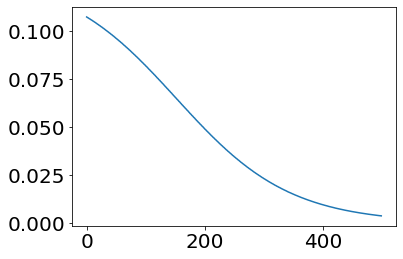

In [19]:
plt.plot(h_hat_base)

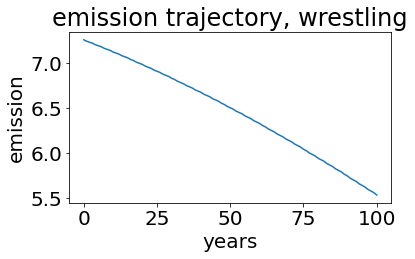

In [20]:
plt.plot(e_base[:101])
plt.ylabel('emission')
plt.xlabel('years')
plt.title('emission trajectory, wrestling')
# plt.savefig("../figures/emssion.png")

### SCC simulation
$X_t = (\log K_t, Z_t, \log N_t)'$ 

\begin{equation}
\begin{aligned}
    - \frac{\delta}{\alpha - i/k} + 1 - \kappa (i/k) = 0 
\end{aligned}
\end{equation}
All annual data:
$$
\alpha = .115, \quad \delta = .008, \quad \kappa = 6.67, \quad \text{and}\quad i/k = .09
$$




SCC is computed according to:
$$
    SCC_t = \frac{\eta[\alpha - i/k] K_t}{ ( 1 - \eta) E_t N_t}
$$
Or another version, no damage in the denominator:
$$
    SCC_t = \frac{\eta[\alpha - i/k] K_t}{ ( 1 - \eta) E_t }
$$


where
$$
  d\log{K_t} = [\mu_k(Z_t) + i/k - \frac{\kappa}{2}(i/k)^2 - \frac{|\sigma_k|^2}{2}]dt + \sigma_k(Z_t)dW_t  
$$
Where initial value:
$$
    C_0 + I_0 = 80 \text{ and } \log{K_0} = 80/\alpha 
$$


$$
    \mu_k(z) = - .046 + .04 \cdot z
$$

$$
\sigma_k(z)' = (.0095, 0, 0) 
$$

$Z_t$ process:
$$
dZ_t = \mu_z(Z_t) dt + \sigma_z(Z_t) dW_t
$$
Where
$$
\mu_z(z) = - .056z
$$

$$
\sigma_z(z)' = (.022, .05, 0) 
$$

$\log{N_t}$ process, exponential linear:
$$
dlogN_t^1 = \iota' Y_t
$$
and
$$
dY_t = \Lambda Y_t dt + \Theta (E_t + E_t \sigma_n dW)
$$

$$
\sigma_n(z) = \lambda E \sigma_n
$$

In [21]:
# set time
T  = 102
size = 500_000

In [22]:
dW = np.random.normal(0,1, (2, size, T))

In [23]:
α = 0.115
η = .032
δ = .01
invkap = .09
κ = (1 - δ/(.115 - .09))/.115
αz = 0
βz = .056
αc0 = 0.00484*4
αc1 = 0.01*4
αz = 0.014*4
σc = np.array([0.00477*2, 0])
σz = np.array([.022, .05])

In [30]:
var_c = np.dot(σc,σc)
var_z = np.dot(σz,σz)
var_c, var_z

(9.10116e-05, 0.002984)

For value function:

$$
    V = v_c \log{c} + v_z z + v_0
$$

$$
\begin{aligned}
v_c =& 96.8\\
v_z =& 58.667
\end{aligned}
$$

$$
\begin{aligned}
    h =& - \frac{v_z \sigma_z + v_c \sigma_c }{\xi_b} \\
      =& - \frac{1}{5}\left[58.67 \begin{bmatrix} .022\\ 0.05 \end{bmatrix}  + 96.8 \begin{bmatrix} 0.00954\\0\end{bmatrix}\right] \\
          =& \begin{bmatrix} - 0.443 \\ - 0.587 \end{bmatrix}
\end{aligned}
$$

In [26]:
vc = (1 - η)/δ
vz = vc*αc1/(δ + αz)
vc, vz

(96.8, 58.666666666666664)

In [27]:
ξb = 5
h = -1/ξb*(vc*σc + vz*σz)
h

array([-0.44282773, -0.58666667])

In [33]:
cov_cz = σc@σz
σz_new = np.array([0, np.sqrt(var_z)])
σc_new = np.array([np.sqrt(var_c -   (cov_cz/σz_new[1])**2), cov_cz/σz_new[1]])
σz_new, σc_new

(array([0.      , 0.054626]), array([0.00873211, 0.00384213]))

In [34]:
ξb = 5
h = -1/ξb*(vc*σc_new + vz*σz_new)
h

array([-0.16905356, -0.71532865])

In [35]:
h@h/8

0.06753427239836444

In [36]:
np.log(2)/(h@h/8)

10.263635868781968

In [ ]:
alpha_k = -0.04600704891304346
beta = .04
sigma_k = np.array([.0095, 0, 0])
k0 = 80/alpha

In [ ]:
logKt = simulate_logkapital(invkap, dW, zt, alpha_k, beta, sigma_k, kappa, k0, dt=1/2)
sigma_n = np.array([0, 0, 1.2])
log_nt = simulate_logn_withdrift(etHigh_median, λ_base/1000, sigma_n, dW, np.zeros(size))

In [ ]:
logKt.shape

In [ ]:
scc_base = simulate_scc(invkap, logKt, etHigh_median, np.zeros(logKt.shape), alpha, delta, eta )

In [ ]:
logkDictOriginal = get_quantile(logKt)
lognDictOriginal = get_quantile(log_nt)

In [ ]:
sccQuantOriginal = get_quantile(scc_base)

In [ ]:
# actual value
fig = plt.figure(figsize = (24, 20))
mpl.rcParams['lines.linewidth'] = 2
plt.subplot(331)
plot_quantile(logkDictOriginal)
# plt.xlabel("years")
plt.xlim(0,200)
# plt.ylabel(r"$\log{K_t} - \log(80/\alpha)$", rotation=0, labelpad=80)
plt.title("log capital")
# plt.savefig("logk_quantile.png")
plt.subplot(332)
plot_quantile(lognDictOriginal)
# plt.xlabel("years")
plt.xlim(0,200)
# plt.ylabel("$\log{N_t}$ \n (scaled by 100)", rotation=0, labelpad=80)
plt.title("log damage")
# plt.savefig("logn_quantile.png")
plt.subplot(333)
plt.plot(np.log(etHigh_median))
# plt.xlabel("years")
plt.xlim(0,200)
# plt.ylabel("log emission", rotation=0, labelpad=80)
plt.title("log emission")

plt.subplot(3,3,(4,9))
plot_quantile(sccQuantOriginal)
plt.xlabel("years")
plt.xlim(0,200)
# plt.ylabel(r"\log SCC - \log SCC_0", rotation=0, labelpad=30)
plt.title("$ \log SCC = logK_t - \log N_t - \log E_t + constant$")
# plt.savefig("../figures/scc_original.png")

In [ ]:
(1/7 - .115)/7 + np.sqrt((delta - .115)/7 + (1/7 + .115)**2/4)

In [ ]:
scc_median = get_quantile(scc_base, quantileList=[.5])

In [ ]:
scc_rfs = pickle.load(open('../data/rfsSCC', "rb"))

In [ ]:
import plotly
from plotly.subplots import make_subplots
import plotly.graph_objs as go
# plt.plot(scc_median[.5])
fig = make_subplots(1,1)
fig.add_trace(go.Scatter(x = np.arange(0,20+1/2, 1/2), y = scc_median[.5],
                   name = 'median SCC , wrestling', line = dict(color = '#1f77b4', dash = 'solid', width = 3),\
                       showlegend = True) )
fig.add_trace(go.Scatter(x = np.arange(0,20+1/4,1/4), y = scc_rfs,
                   name = 'SCC, RFS', line = dict(color = 'red', dash = 'dot', width = 3),\
                          showlegend = True))

fig.update_layout(legend=dict(
    yanchor="top",
    y=0.99,
    xanchor="left",
    x=0.01,
    font=dict(size = 18),
),
    plot_bgcolor ="white"
)

fig.update_xaxes(showline=True, linewidth=2, linecolor='black', title="years")
fig.update_yaxes(showline=True, linewidth=2, linecolor='black', title="SCC")

fig.update_layout(
    autosize=False,
    width=700,
    height=600,
    margin=dict(
        l=50,
        r=50,
        b=100,
        t=100,
        pad=4
    ),
)


fig.show()

In [ ]:
e_rfs = pickle.load(open('../data/rfsEmission', "rb"))

In [ ]:
years = [i*4 for i in range(100)]

In [ ]:
e_rfs[years].shape

In [ ]:
import plotly
from plotly.subplots import make_subplots
import plotly.graph_objs as go
# plt.plot(scc_median[.5])
fig = make_subplots(1,1)

fig.add_trace(go.Scatter(x = np.arange(0,20+1/4,1/4), y = e_rfs,
                   name = 'emission, RFS', line = dict(color = 'red', dash = 'dot', width = 3),\
                          showlegend = True))
fig.add_trace(go.Scatter(x = np.arange(0,20 + 1/2, 1/2), y = etHigh_median,
                   name = 'emission high , wrestling', line = dict(color = '#1c1c1c', dash = 'solid', width = 3),\
                       showlegend = True) )
# fig.add_trace(go.Scatter(x = np.arange(0,101), y = e_low,
#                    name = 'emission , wrestling', line = dict(color = '#1f77b4', dash = 'solid', width = 3),\
#                        showlegend = True) )
fig.update_layout(legend=dict(
    yanchor="top",
    y=0.99,
    xanchor="left",
    x=0.6,
    font=dict(size = 18),
),
    plot_bgcolor ="white"
)

fig.update_xaxes(showline=True, linewidth=2, linecolor='black', title="years")
fig.update_yaxes(showline=True, linewidth=2, linecolor='black', title="emission")

fig.update_layout(
    autosize=False,
    width=700,
    height=600,
    margin=dict(
        l=50,
        r=50,
        b=100,
        t=100,
        pad=4
    ),
)


fig.show()

In [ ]:
damage_rfs = pickle.load(open("../data/rfsDamage", "rb"))

In [ ]:
import plotly
from plotly.subplots import make_subplots
import plotly.graph_objs as go
# plt.plot(scc_median[.5])
fig = make_subplots(1,1)


fig.add_trace(go.Scatter(x = np.arange(0,101), y = NtQuant[.5],
                   name = r"$ \text{median } N_t,\text{ wrestling }$", line = dict(color = '#1f77b4', dash = 'solid', width = 3),\
                       showlegend = True) )

fig.add_trace(go.Scatter(x = np.arange(0,100+1/4,1/4), y = np.exp(damage_rfs),
                   name = r"$N_t, RFS$", line = dict(color = 'red', dash = 'dot', width = 3),\
                          showlegend = True))

fig.update_layout(legend=dict(
    yanchor="top",
    y=0.99,
    xanchor="left",
    x=0.00,
    font=dict(size = 12),
    itemwidth=50
),
    plot_bgcolor ="white"
)

fig.update_xaxes(showline=True, linewidth=2, linecolor='black', title="years")
fig.update_yaxes(showline=True, linewidth=2, linecolor='black', title="$N_t$")

fig.update_layout(
    autosize=False,
    width=700,
    height=600,
    margin=dict(
        l=50,
        r=50,
        b=100,
        t=100,
        pad=4
    ),
)


fig.show()

In [ ]:
np.log(eta/(1 - eta)*(.2 - .125))

In [ ]:
sccQuantOriginal[.5][-1]

In [ ]:
logkDictOriginal[.5][101], np.log(e_base_102[101])

In [ ]:
np.log(1000) + np.log(eta/(1 - eta)*(.2 - .125))

In [ ]:
sccQuantOriginal[.5][-1],sccQuantOriginal[.5][0]

In [ ]:
logkDict = get_quantile(logKt*100 - np.log(k0)*100)
lognDict = get_quantile(log_nt*100)
scc_diff = np.zeros((size, T))
for t in range(T):
    scc_diff[:,t] = scc_base[:,t]/scc_base[:,0]
sccQuant = get_quantile(np.log(scc_diff)*100)

In [ ]:
# for decompose
fig = plt.figure(figsize = (24, 20))
mpl.rcParams['lines.linewidth'] = 2
plt.subplot(331)
plot_quantile(logkDict)
# plt.xlabel("years")
plt.xlim(0,100)
# plt.ylabel(r"$\log{K_t} - \log(80/\alpha)$", rotation=0, labelpad=80)
plt.title("$\log{K_t} - \log{K_0}  $ \n (scaled by 100)")
# plt.savefig("logk_quantile.png")
plt.subplot(332)
plot_quantile(lognDict)
# plt.xlabel("years")
plt.xlim(0,100)
# plt.ylabel("$\log{N_t}$ \n (scaled by 100)", rotation=0, labelpad=80)
plt.title("log damage \n (scaled by 100)")
# plt.savefig("logn_quantile.png")
plt.subplot(333)
plt.plot((np.log(e_base_102) - np.log(e_base_102[0]))*100)
# plt.xlabel("years")
plt.xlim(0,100)
# plt.ylabel("log emission", rotation=0, labelpad=80)
plt.title("log emission: $\log e - \log e_0$ \n (scaled by 100)")

plt.subplot(3,3,(4,9))
plot_quantile(sccQuant)
plt.xlabel("years")
plt.xlim(0,100)
# plt.ylabel(r"\log SCC - \log SCC_0", rotation=0, labelpad=30)
plt.title("$\log SCC - \log SCC_0$ \n (scaled by 100)")
plt.savefig("../figures/scc_component.png")

In [ ]:
np.exp(lognDictOriginal[.5])

# tenuous belief check

$\hat \alpha_k = -.05 $  and $.01\hat \sigma_k = .0095$

$ \hat\alpha_c = .02$  and $\hat \beta_c = .04 $

$\hat\alpha = 0 $ and $\hat\beta_z = .056$

and compute coefficient for consumption:
$$
\begin{aligned}
    \hat \alpha_c &= 100(i^* - \frac{\kappa}{2} (i^*)^2) + \alpha_k - \frac{(.01\sigma_k)^2}{2} \\
                  &\approx 100\times.02
\end{aligned}
$$

The consumption process:
$$
dlogC_t = (\alpha_c + \beta_c z)dt + \sigma_c dWt
$$

The Z process:
$$
dZ_t = (\alpha_z - \beta_z Z)dt + \sigma_z dW_t
$$

with  $\sigma = \begin{bmatrix} \sigma_c' \\ \sigma_z'\end{bmatrix} = \begin{bmatrix} .0095, & 0\\
                                .022, & .05\end{bmatrix}$

In [22]:
# alpha_c = .484*4*0.01
# beta_c = .04
T = 102
size = 100_000
dW = np.random.normal(0,1,size=(3, size, T))

In [23]:
sig_z = np.sqrt((.022**2 + .05**2)/(1 - (1 - .056)**2))
sig_z

0.1655607044403692

In [24]:
Z0 = np.random.normal(0, sig_z, size=(size))

In [ ]:
dW = np.random.normal(0,1,size=(3, size, 100*11))
sigma_z = np.array([.022, .05, 0])/np.sqrt(100)
Zt = simulate_z(dW, Z0, 0, .056/100, sigma_z)

In [ ]:
plt.hist(Zt[:,0], bins=200, density=True)
plt.show()

In [ ]:
np.std(Zt[:,0])

In [ ]:
ZtQuant = get_quantile(Zt, quantileList=[.1, .9])

In [ ]:
fig = plt.figure(figsize=(5,4))
plt.plot(ZtQuant[.1])
plt.plot(ZtQuant[.9])

In [ ]:
sigma_c = np.array([.477*2/100, 0, 0])

In [ ]:
dW = np.random.normal(0,1,size=(3, size, 100*11))
sigma_c = np.array([.95, 0, 0])/np.sqrt(100)
logCt = simulateLogConsumption(Zt, dW, 2/100, 4/100, sigma_c)

In [ ]:
for i in range(40):
    plt.plot(logCt[i])

In [ ]:
Zt[0,:3]

In [ ]:
sigma_z = np.array([.022, .05, 0])
np.dot(sigma_z, dW[:, 0, :3])

In [ ]:
logCtQuantile = get_quantile(logCt, quantileList=[.1, .9])

In [ ]:
for quantile in [.9, .1]:
    plt.plot(logCtQuantile[quantile], label="{} quantile".format(quantile) , linestyle="dashed", linewidth=3)

plt.fill_between(x=np.arange(0,11*100), y1=logCtQuantile[.1], y2=logCtQuantile[.9], color="gray", alpha=.5)
plt.legend()
plt.xlabel('years')
plt.ylabel('$\logC_1 - \logC_0$ \n(scaled by 100)', rotation=0, labelpad=75)
plt.ylim(-5,30)
plt.xlim(0,10*100)
plt.xticks(np.arange(0,11*100, 100), [i for i in range(11)])
# plt.savefig("consumption_growth10.png")
plt.show()

In [ ]:
import pandas as pd

In [ ]:
arry = np.array([logCtQuantile[.1][:11],logCtQuantile[.9][:11]])

In [ ]:
print('quantiles for logCt')
pd.DataFrame(arry, index=[".1 quantile", ".9 quantile"]).round(2)

In [ ]:
zarray = np.array([ZtQuant[.1], ZtQuant[.9]])

In [ ]:
print('quantiles for z')
pd.DataFrame(zarray[:,:11], index=[".1 quantile", ".9 quantile"]).round(2)

In [ ]:
arry10 = np.array([logCtQuantile[.1][-11:],logCtQuantile[.9][-11:]])

In [ ]:
(pd.DataFrame(arry10)).round(2)

# Quarterly simulation

In [ ]:
alpha_c = .484
alpha_c
dWW = np.random.normal(0, 1, size = (2, 2_000_000, 42))

In [ ]:
np.sqrt((.011**2 + .025**2)/(1 - (1-0.014)**2))

In [ ]:
sigma_zz = np.array([.011, .025])
ZZ0 = np.random.normal(0, .163, size=(2_000_000))
ZZt = simulate_z(dWW, ZZ0, 0, .014, sigma_zz)

In [ ]:
ZZtQuant = get_quantile(ZZt, quantileList=[.1,.9])

In [ ]:
plt.figure(figsize=(5,4))
plt.plot(ZZtQuant[.1])
plt.plot(ZZtQuant[.9])

In [ ]:
sigma_c = np.array([.477, 0])
alpha_c =.484
logCCt = simulateLogConsumption(ZZt, dWW, .484, 1, sigma_c, dt = 1/4)

logCCtQuantile = get_quantile(logCCt, quantileList=[.1, .9])

In [ ]:
logCCt[:,0]

In [ ]:
logCCt.shape

In [ ]:
for quantile in [.9, .1]:
    plt.plot(logCCtQuantile[quantile][:5], label="{} quantile".format(quantile) , color="black", linestyle="dashed", linewidth=3)

plt.fill_between(x=np.arange(0,5), y1=logCCtQuantile[.1][:5], y2=logCCtQuantile[.9][:5], color="gray", alpha=.5)
# plt.legend()
plt.xlabel('Quarters')
plt.ylabel('$\logC_1 - \logC_0$ \n(scaled by 100)', rotation=0, labelpad=75)
# plt.ylim(-5,30)
# plt.xlim(0,40)
# plt.savefig('consumption_growth010.png')

In [ ]:
for quantile in [.9, .1]:
    plt.plot(logCCtQuantile[quantile], label="{} quantile".format(quantile) , color="black", linestyle="dashed", linewidth=2)

plt.fill_between(x=np.arange(0,42), y1=logCCtQuantile[.1], y2=logCCtQuantile[.9], color="gray", alpha=.5)
# plt.legend()
plt.xlabel('Quarters')
plt.ylabel('$\logC_1 - \logC_0$ \n(scaled by 100)', rotation=0, labelpad=75)
plt.ylim(-5,30)
plt.xlim(0,40)
# plt.savefig('consumption_quarter.png')

In [ ]:
years = np.array([i*4 for i in range(10+1)])
years

In [ ]:
print('logCt quantiles for 10 years, quarterly simulation')
pd.DataFrame([logCCtQuantile[.1][years], logCCtQuantile[.9][years]], index=['.1 quantile', '.9 quantile']).round(2)

In [ ]:
print('logCt quantiles for first 4 quarters')
pd.DataFrame([logCCtQuantile[.1][:5], logCCtQuantile[.9][:5]], index=['.1 quantile', '.9 quantile'], 
             columns=["0", 'quarter 1', 'quarter 2', 'quarter 3 ', 'quarter 4' ]).round(3)

In [ ]:
ZZtQuant = get_quantile(ZZt, quantileList=[.1,.9])

In [ ]:
print('z quantiles for 10 years, , quarterly simulation')
pd.DataFrame([ZZtQuant[.1][years], ZZtQuant[.9][years ]], index=['.1 quantile', '.9 quantile']).round(2)

In [ ]:
for quantile in [.9, .1]:
    plt.plot(logCCtQuantile[quantile][:10], label="{} quantile".format(quantile) , linestyle="dashed", linewidth=4)

plt.fill_between(x=np.arange(0,10), y1=logCCtQuantile[.1][:10], y2=logCCtQuantile[.9][:10], color="gray", alpha=.5)
plt.legend()
plt.xlabel('years')
plt.ylabel('$\logC_1 - \logC_0$ \n(scaled by 100)', rotation=0, labelpad=75)
# plt.savefig('consumption_growth0100.png')

# Compute implied distortion for logk, z and n
$$
\sigma_k' h^* = - \frac{v_k \sigma_k'\sigma_k + \frac{d \psi (z)}{dz} \cdot \sigma_k' \sigma_z}{\xi_m}
$$
where
$$
v_k = 1 - \eta
$$

Extract k, y and min-max problem:
$$
\delta \phi(r) + \delta \psi(z) =  \delta[(1 - \eta) \log{(\alpha - i^*)} + \eta \log{e^*} - \iota_1 z] - \frac{\xi_m}{2} (h^*)'h^* + v_k(\mu_k(z) + i^* - \frac{\kappa}{2}(i^*)^2 - \sigma_k^2/2 ) + v_y'\Theta e^* - \frac{d\phi}{dr}e^* + \frac{d\psi}{dz}\mu_z(z) + \frac{1}{2}trace(\sigma_z' \frac{d^2 \psi}{dz^2} \sigma_z) 
$$

set
$$
\tau_1 = - v_y'\Theta = median * \gamma_{base}
$$

In equilibrium $e^*$ satisfies:
$$
- \tau_1 e^*  - \frac{d\phi}{dr}e^* =   \tau_2 (e^*)^2 - \delta \eta 
$$

The ODE:
$$
\delta \psi(z) =   - \frac{\frac{d\psi}{dz} v_k (\sigma_k'\sigma_z + \sigma_z'\sigma_k ) + (\frac{d\psi}{dz})^2 \sigma_z'\sigma_z }{2\xi_m} + \frac{d\psi}{dz} \mu_z(z)  + \frac{1} {2}\frac{d^2 \psi}{dz^2}\sigma_z' \sigma_z + \delta[(1 - \eta) \log{(\alpha - i^*)}  - \iota_1 z]  + v_k(\mu_k(z) + i^* - \frac{\kappa}{2}(i^*)^2 - \sigma_k^2/2 )
$$

Temporarily set $\iota_2 = 0$

The $\psi(z)$ is linear in $z$:
$$
\psi(z) = v_z z + v_0
$$

If we know that $\psi(z) = v_z\cdot z + v_0$

coefficient of z should be 0:

$$
 - \delta v_z z  +  v_k\cdot (\beta_k - \iota_2) z + v_z\cdot(- \beta_z z) = 0 
$$

$$
- \delta v_z z - .056 v_z z  + .01 (1 - \eta)z = 0
$$

$$
\begin{aligned}
 v_z = \frac{.04(1 - \eta)}{\delta + .056}
\end{aligned}
$$
Thus
$$
v_z = \frac{ -\delta \iota_2  + v_k \beta_k}{\delta + \kappa} = (1 - .032)\cdot .04 /(.008 + .056)
$$

In [ ]:
sigma_k = np.array([.0095, 0, 0])
sigma_z = np.array([.022, .05, 0])

xi_m = .00256
i = .125
alpha = .2
eta = .032
delta = .008

In [ ]:
alpha_z = 0.
beta_z = .056
sigma_z = np.array([.022, .05, 0])

In [ ]:
alpha_k = -.05
beta_k = .04
kappa = 7
k0 = 80/alpha
sigma_k = np.array([.0095, 0, 0])

In [ ]:
v_z = beta_k*(1 - eta)/(delta + beta_z)
v_k = 1 - eta
v_z, v_k

In [ ]:
y = (v_k*sigma_k + v_z*sigma_z)

In [ ]:
xi = np.sqrt(np.sum(y**2/2)/(.1**2/2 ))
xi

In [ ]:
h_raw = - (v_k*sigma_k + v_z*sigma_z)/xi_m
h_raw                                                                     

In [ ]:
h_capital = np.dot(sigma_k, h_raw)
h_capital

In [ ]:
h_z = np.dot(sigma_z, h_raw)
h_z/0.056

In [ ]:
x = np.zeros((size,3))
x[:] = h_raw

In [ ]:
sigma_z

In [ ]:
dW = np.random.normal(0,1,size = (3, 100_000, 102))
sig_z = np.sqrt((.022**2+ .05**2)/(1 - (1-.056)**2))
print(sig_z)
z0 = np.random.normal(h_z/.056, sig_z, size=(size))
Z_d = simulate_z(dW, z0, 0, 0.056, sigma_z, x.T)
ZtQuant_d = get_quantile(Z_d, quantileList=[.1, .9])

In [ ]:
plot_quantile(ZtQuant_d, quantileList=[.1, .9])

In [ ]:
logK_d = simulate_logkapital(.125, dW, Z_d, alpha_k, beta_k, sigma_k, kappa, k0, x.T)
logKQuant_d = get_quantile(logK_d)

In [ ]:
plot_quantile(logKQuant_d)
plt.xlabel("years")
plt.ylabel(r'$\log{K_t}$', rotation=0, labelpad=30)
# plt.title('SCC, no damage')

In [ ]:
sigma_c = np.array([.477, 0, 0])

In [ ]:
logC = simulateLogConsumption(Z_d, dW, 2, 4, sigma_c, dt = 1)
logCQuant = get_quantile(logC)

In [ ]:
plot_quantile(logCQuant)

In [ ]:
sigma_n = np.array([0, 0, 1.2])
log_n = simulate_logn_withdrift(e_base_102, λ_base/1000, sigma_n, dW, h_hat_base)

In [ ]:
log_n_quantile = get_quantile(log_n)

In [ ]:
plot_quantile(log_n_quantile)
plt.show()

In [ ]:
SCC = simulate_scc(invkap, logK_d, e_base_102, log_n, alpha, delta, eta )
SCCQuant = get_quantile(SCC)

In [ ]:
mpl.rcParams['lines.linewidth'] = 3

fig = plt.figure(figsize = (26,26))
# plt.subplots_adjust(wspace= 0.25, hspace= 0.25)
plt.suptitle("With drift distortion", fontsize=40)
sub1 = fig.add_subplot(5,3,1) # two rows, two columns, fist cell
plot_quantile(ZtQuant_d, quantileList=[.1, .9])
plt.title('z')

sub1 = fig.add_subplot(5,3,2)
plot_quantile(logKQuant_d)
plt.title('$\logK_t$')
sub1 = fig.add_subplot(5,3,3)
plot_quantile(log_n_quantile)
plt.title('$\logN_t$')

sub2 = fig.add_subplot(5,3,(4,9))
plot_quantile(SCCQuant)
plt.title('$SCC1$, (without $N_t*$ in the denominator)')

# sub2 = fig.add_subplot(5,3,(10,15))
# plot_quantile(SCC2Quant)
# plt.title('$SCC2$, (with $N_t*$ in the denominator)')
# plt.xlabel('years')
# # plt.savefig('With_distortion.png')